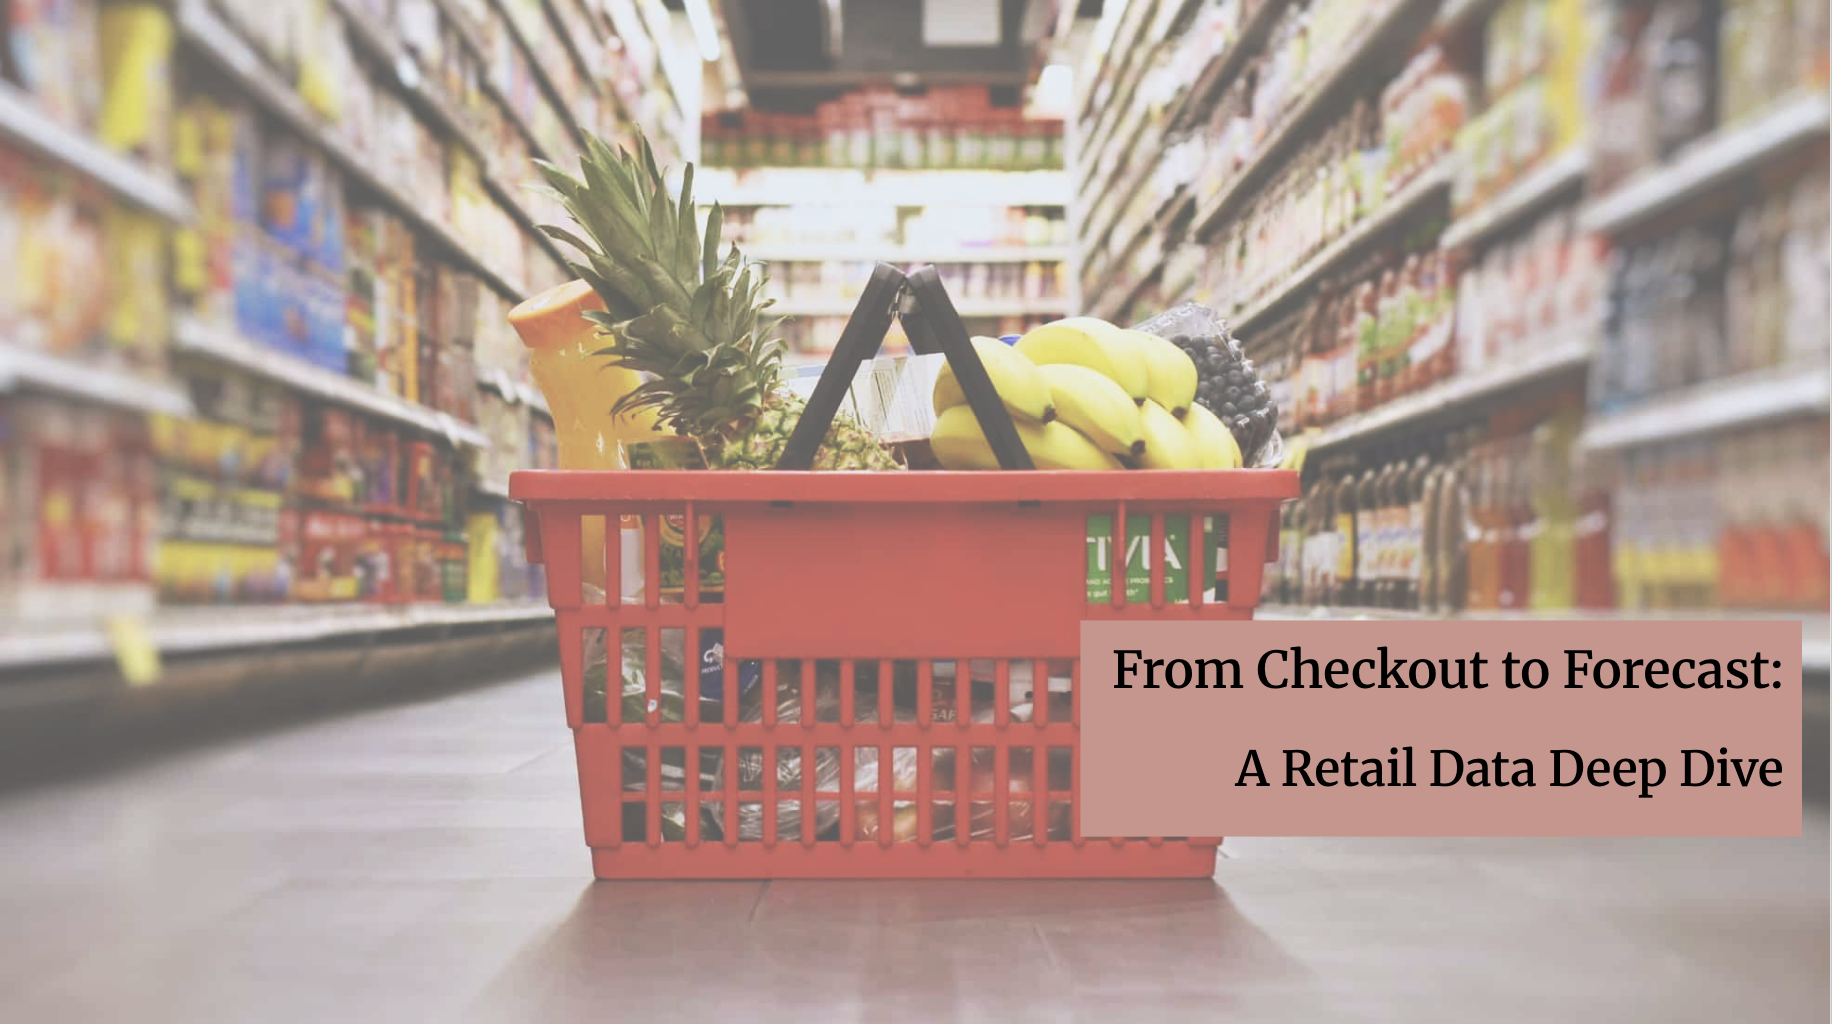

# Project Overiew

The goal of this project is to forecast daily unit sales for a major retail chain across multiple stores and thousands of items. Accurate forecasting supports inventory management, logistics, and promotional planning.


### About the dataset

The data can be found on Kaggle [here](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data).

The dataset is based on real-world sales data from Corporación Favorita, a large Ecuadorian-based grocery retailer. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

The data includes:

* `Transactions`: Daily unit sales per store-item-date
*	`Item metadata`: Family, class, perishability
*	`Store metadata`: City, type, cluster
*	`Holiday events`: Local and national holidays, transferred events
*	`Oil prices` : External data

We excluded transactions.csv from this analysis, as unit-level sales were already available and aligned with our forecasting objective.

### Project Workflow

1.	**Data Exploration**
  * Missing values, negative sales, top families
  *	Outlier analysis and Z-score investigation

2.	**Data Preparation**
  *	Date completion per item-store
  *	Filtering for active combinations
  *	Cleaning returns and missing promotion flags

3.	**Feature Engineering**
  *	Time features, holiday indicators
  *	Lag and rolling statistical features

4.	**Modeling**
  *	XGBoost baseline with evaluation
  *	LSTM model comparison
  *	MLflow experiment tracking and model versioning



In this notebook, I perform **exploratory data analysis (EDA)** on the cleaned and enriched training dataset used for retail sales forecasting.

This step aims to uncover temporal trends, sales behavior across different dimensions (time, geography, promotion, holidays), and feature relationships to support robust model development.

# Libraries and Data Loading

We start by importing essential libraries for analysis and plotting. The training data has been pre-filtered and exported in CSV format. It is loaded in chunks to handle memory efficiently.

In [2]:
import pandas as pd
import numpy as np
import gc
import datetime
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

import os
import sys

In [3]:
# Go one directory up and then into Utils/
UTILS_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'Utils'))
if UTILS_PATH not in sys.path:
    sys.path.append(UTILS_PATH)

from utils import summarize_data

In [4]:
# Initialize an empty list for chunks and set chunk size
print("\nStep 1: Loading pre-filtered training data in chunks...")
chunks = []
chunk_size = 10**6

# Read the CSV file in chunks
for chunk in pd.read_csv('../00_Data/Prepared_Data/train_full.csv', chunksize=chunk_size):
    # Append the chunk to the list
    chunks.append(chunk)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all chunks into a single DataFrame
print("\nStep 2: Combining chunks...")
df_train = pd.concat(chunks, ignore_index=True)
print(f"Combined dataset: {df_train.shape[0]:,} rows")

# Clean up to free memory
print("\nStep 3: Cleanup...")
del chunks
gc.collect()
print("\n✅ Data loading complete!")


Step 1: Loading pre-filtered training data in chunks...

Step 2: Combining chunks...
Combined dataset: 3,386,043 rows

Step 3: Cleanup...

✅ Data loading complete!


In [26]:
df_oil = pd.read_csv('../00_Data/Raw_Data/oil.csv')

# Dataset Overview

Here we inspect the structure and volume of the dataset, including:

* Total number of rows and features
*	Time range covered
*	Store and item coverage
*	Average daily sales and sparsity of the target variable (unit_sales)

In [5]:
pd.set_option('display.max_columns', None)
df_train.head()

store_nbr  item_nbr        date  id  unit_sales  onpromotion       city  \
0         24     96995  2013-01-02 NaN         0.0        False  Guayaquil   
1         24     96995  2013-01-03 NaN         0.0        False  Guayaquil   
2         24     96995  2013-01-04 NaN         0.0        False  Guayaquil   
3         24     96995  2013-01-05 NaN         0.0        False  Guayaquil   
4         24     96995  2013-01-06 NaN         0.0        False  Guayaquil   

    state store_type  store_cluster item_family  item_class  perishable  \
0  Guayas          D              1   GROCERY I        1093           0   
1  Guayas          D              1   GROCERY I        1093           0   
2  Guayas          D              1   GROCERY I        1093           0   
3  Guayas          D              1   GROCERY I        1093           0   
4  Guayas          D              1   GROCERY I        1093           0   

  holiday_type holiday_locale holiday_transferred  year  quarter  month  day  \
0          NaN            NaN                 NaN  2013        1      1    2   
1          NaN            NaN                 NaN  2013        1      1    3   
2          NaN            NaN                 NaN  2013        1      1    4   
3     Work Day       National               False  2013        1      1    5   
4          NaN            NaN                 NaN  2013        1      1    6   

   day_of_week  is_weekend  day_of_year  week_of_year  is_holiday  \
0            2           0            2             1       False   
1            3           0            3             1       False   
2            4           0            4             1       False   
3            5           1            5             1        True   
4            6           1            6             1       False   

   is_transferred_holiday  is_actual_holiday  is_additional_event  \
0                   False              False                False   
1                   False              False                False   
2                   False              False                False   
3                   False              False                False   
4                   False              False                False   

   is_transfer_day  is_national_event  is_local_event  lag_1  lag_7  lag_14  \
0            False              False           False    NaN    NaN     NaN   
1            False              False           False    0.0    NaN     NaN   
2            False              False           False    0.0    NaN     NaN   
3            False               True           False    0.0    NaN     NaN   
4            False              False           False    0.0    NaN     NaN   

   lag_28  unit_sales_3d_avg  unit_sales_7d_avg  unit_sales_14d_avg  \
0     NaN                NaN                NaN                 NaN   
1     NaN                NaN                NaN                 NaN   
2     NaN                NaN                NaN                 NaN   
3     NaN                0.0                NaN                 NaN   
4     NaN                0.0                NaN                 NaN   

   unit_sales_30d_avg  unit_sales_7d_std  unit_sales_14d_std  
0                 NaN                NaN                 NaN  
1                 NaN                NaN                 NaN  
2                 NaN                NaN                 NaN  
3                 NaN                NaN                 NaN  
4                 NaN                NaN                 NaN

In [6]:
summarize_data(df_train)

Dataset shape: (3386043, 41)
Date range: 2013-01-02 to 2014-03-31
Number of stores: 10
Number of items: 1127
Average daily unit_sales: 3.97
Zero unit_sales percentage: 47.25%


In [7]:
# Set style for better looking plots
plt.style.use('default')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

We convert the date column to datetime format for further time-based exploration.

In [8]:
df_train['date'] = pd.to_datetime(df_train['date'])

# Time Series Behavior Analysis

To better understand demand dynamics for modeling, we analyzed the time series of `unit_sales` for one top-performing store-item combination.
* **Seasonal Decomposition**: Clear weekly seasonality and minor long-term trend observed.
*	**ACF/PACF Plots**: Strong autocorrelation at lags 1 and 7, confirming importance of lag features.
*	**Stationarity Check (ADF Test)**: Series is non-stationary, supporting the need for differencing in classical models.

This analysis supports our decision to engineer lag/rolling features and explore LSTM and XGBoost for capturing complex temporal patterns.

## Time Series Decomposition

To better understand the underlying patterns in sales, we applied seasonal decomposition to the daily aggregated unit sales using the `seasonal_decompose` method. This process allows us to break down the series into three components:

* **Trend**: Long-term progression or movement in sales.
*	**Seasonal**: Recurring patterns at regular intervals (weekly in this case).
*	**Residuals**: Random noise not explained by the trend or seasonality.

> **Key Observations:**
* A clear weekly seasonal pattern is visible, with consistent fluctuations aligned to the 7-day retail cycle.
* The trend component shows notable peaks during certain retail periods, potentially linked to promotions, holidays, or high-demand seasons.
*	The residuals appear relatively stable outside of certain spikes, likely tied to external events or data anomalies.

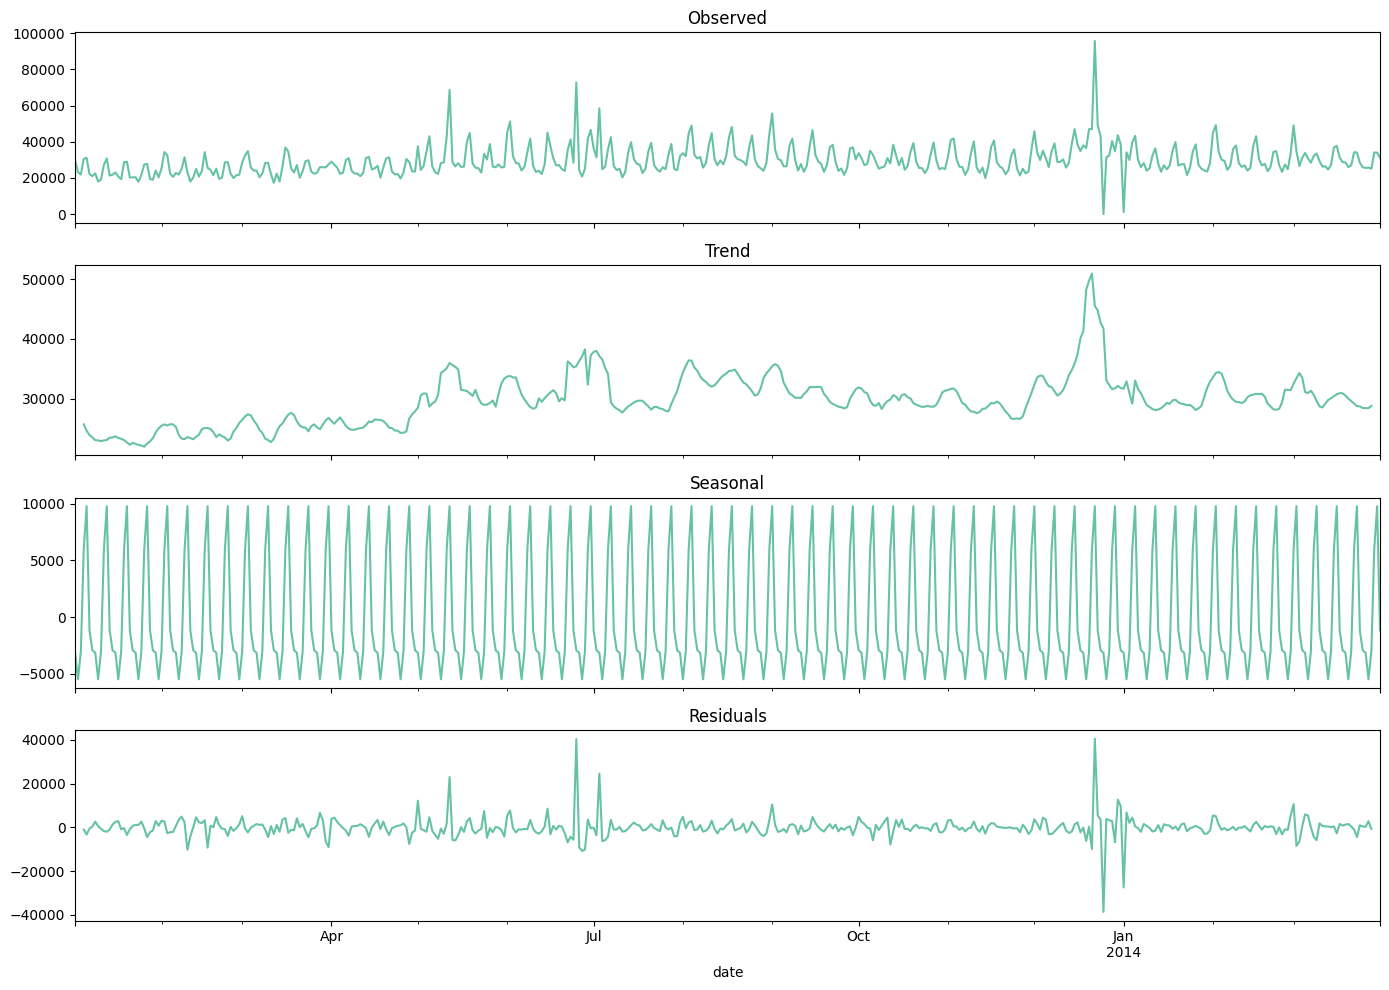

In [9]:
daily_sales = df_train.groupby('date')['unit_sales'].sum()

# Time Series Decomposition
decomposition = seasonal_decompose(daily_sales, model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residuals')
plt.tight_layout()
plt.show()

## Stationarity Check: Augmented Dickey-Fuller (ADF) Test

Stationarity is an essential property for many classical time series forecasting models like ARIMA. We used the ADF test to determine if the daily sales series is stationary.



> **Interpretation:**
* The test statistic is below the 5% critical value, and the p-value is below 0.05, indicating that we can reject the null hypothesis.
*	**Conclusion**: The time series is likely stationary, which supports the use of classical models such as ARMA/ARIMA.



In [10]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(daily_sales)
print("\nADF Test Results:")
print(f"Test Statistic: {adf_result[0]:.3f}")
print(f"p-value: {adf_result[1]:.5f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.3f}")
if adf_result[1] <= 0.05:
    print("✅ The series is likely stationary.")
else:
    print("⚠️ The series is likely non-stationary.")


ADF Test Results:
Test Statistic: -3.015
p-value: 0.03356
Critical Values:
  1%: -3.445
  5%: -2.868
  10%: -2.570
✅ The series is likely stationary.


## ACF and PACF Analysis

We also visualized:
* **ACF (Autocorrelation Function)**: to inspect the persistence of past values in the series.
*	**PACF (Partial Autocorrelation Function)**: to identify significant lags after accounting for prior ones.

> **Key Takeaways:**
*	The ACF plot shows a gradual decay, suggesting some autoregressive structure.
*	The PACF plot has significant spikes at early lags (e.g., lag 1 and lag 7), indicating potential for AR terms.
*	These insights will guide the parameter selection for classical models like ARIMA or SARIMA.



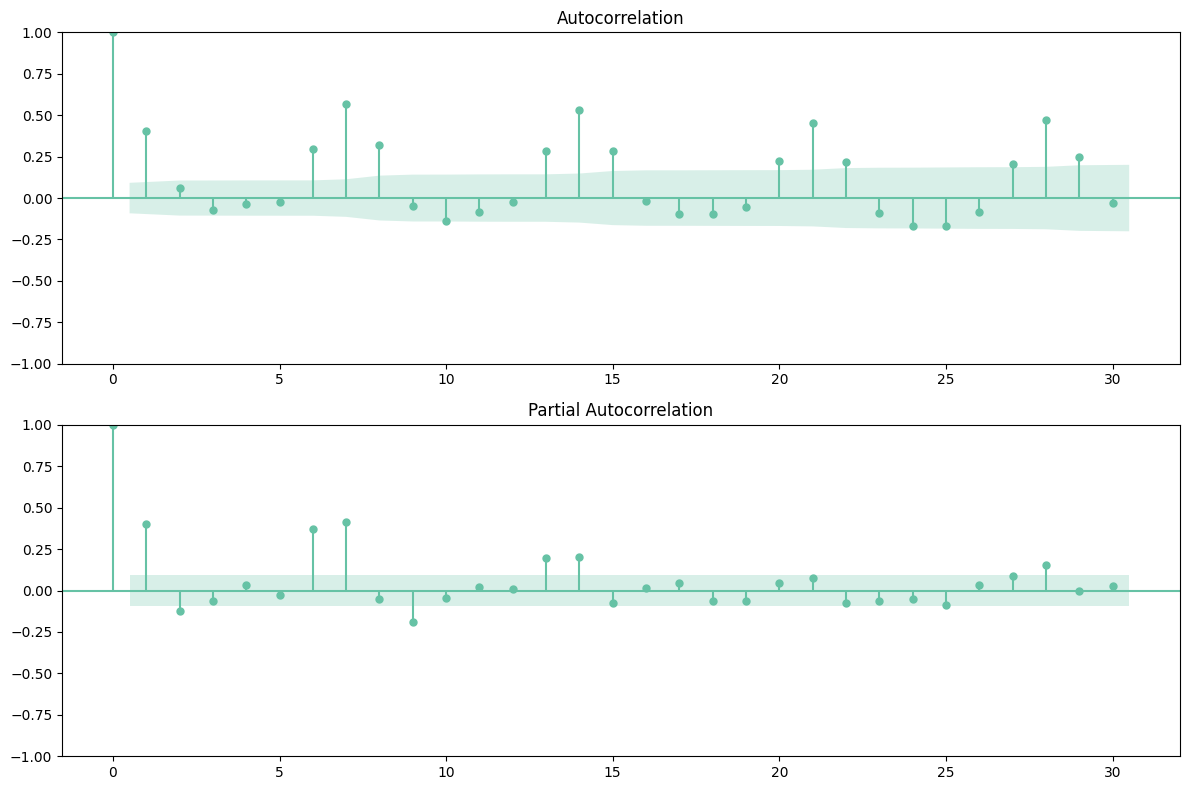

In [11]:
# ACF & PACF Plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(daily_sales, ax=ax[0], lags=30)
plot_pacf(daily_sales, ax=ax[1], lags=30)
plt.tight_layout()
plt.show()

# Exploratory Data Analysis

## Sales Trends Over Time

We explore how **total sales** vary over time, including daily, monthly, and yearly trends. These plots help identify seasonality, holiday spikes, and longer-term patterns.

Plots included:

*	Daily Sales Trend
*	Monthly Sales Trend
*	Yearly Sales Comparison
*	Sales Distribution (log-scale)

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Daily sales trend
daily_sales = df_train.groupby('date')['unit_sales'].sum().reset_index()
axes[0,0].plot(daily_sales['date'], daily_sales['unit_sales'], linewidth=1, alpha=0.7)
axes[0,0].set_title('Daily Sales Trend Over Time', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Total Unit Sales')
axes[0,0].tick_params(axis='x', rotation=45)

# Monthly aggregation for cleaner view
monthly_sales = df_train.groupby([df_train['date'].dt.to_period('M')])['unit_sales'].sum()
axes[0,1].plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o', linewidth=2)
axes[0,1].set_title('Monthly Sales Trend', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Total Unit Sales')
axes[0,1].tick_params(axis='x', rotation=45)

# Yearly trend
df_train['year'] = df_train['date'].dt.year
yearly_sales = df_train.groupby('year')['unit_sales'].sum()
axes[1,0].bar(yearly_sales.index, yearly_sales.values, alpha=0.7)
axes[1,0].set_title('Yearly Sales Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Total Unit Sales')
axes[1,0].set_xticks(yearly_sales.index)
axes[1,0].set_xticklabels([str(int(y)) for y in yearly_sales.index])

# Sales distribution
axes[1,1].hist(df_train['unit_sales'], bins=100, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Sales Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Unit Sales')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_yscale('log')  # Log scale due to likely skewed distribution

plt.tight_layout()
plt.show()

## Seasonal Patterns

We explore how **average unit sales** behave across time-based dimensions:

*	Month
*	Day of the week
*	Weekend vs Weekday
*	Quarter


> **Insights:** Higher sales on weekends and seasonal differences across months




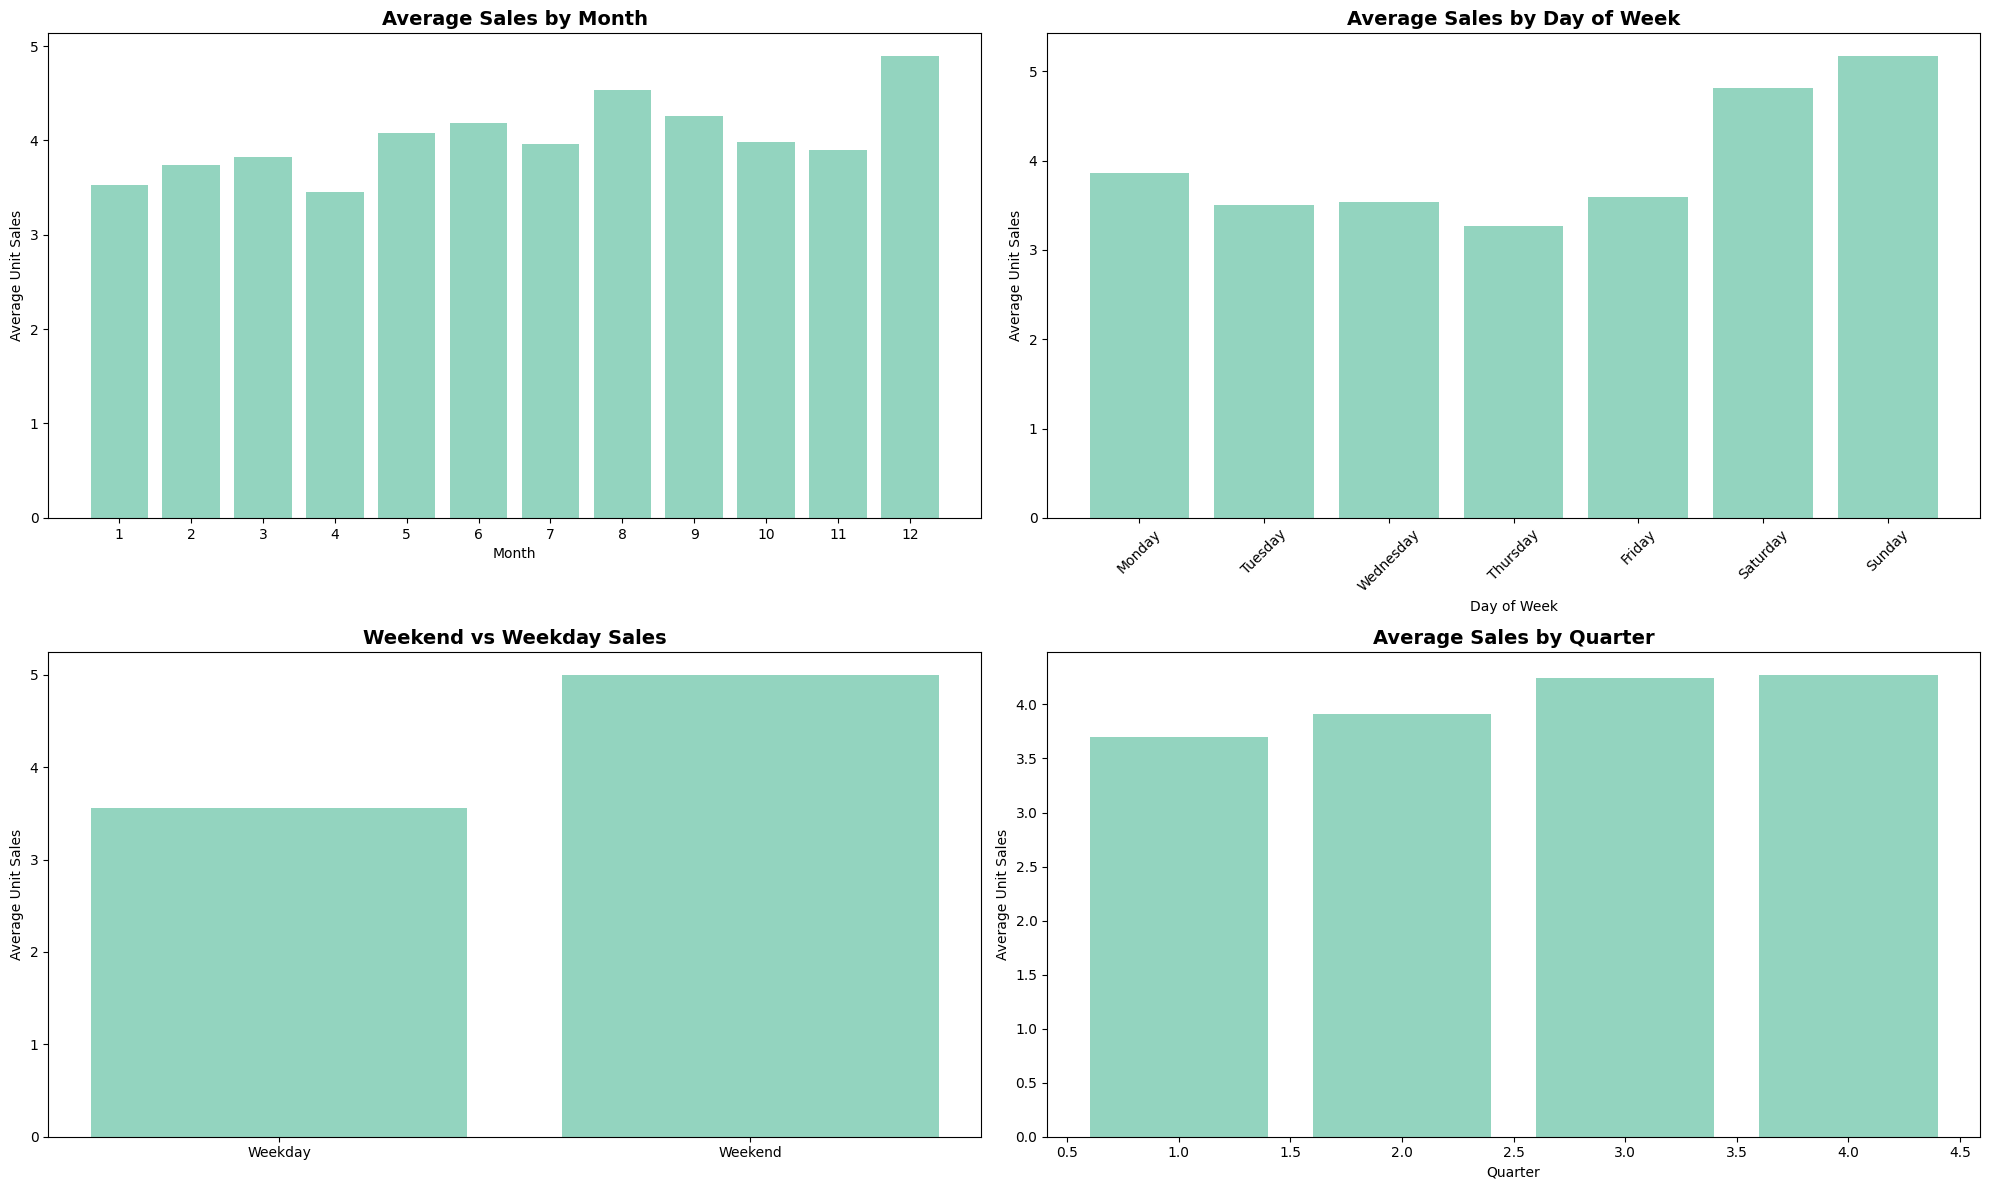

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Monthly seasonality
monthly_pattern = df_train.groupby('month')['unit_sales'].mean()
axes[0,0].bar(monthly_pattern.index, monthly_pattern.values, alpha=0.7)
axes[0,0].set_title('Average Sales by Month', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Unit Sales')
axes[0,0].set_xticks(range(1, 13))

# Day of week pattern
dow_pattern = df_train.groupby('day_of_week')['unit_sales'].mean()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[0,1].bar(range(len(dow_pattern)), dow_pattern.values, alpha=0.7)
axes[0,1].set_title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Average Unit Sales')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(day_names, rotation=45)

# Weekend vs weekday
weekend_sales = df_train.groupby('is_weekend')['unit_sales'].mean()
axes[1,0].bar(['Weekday', 'Weekend'], weekend_sales.values, alpha=0.7)
axes[1,0].set_title('Weekend vs Weekday Sales', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Average Unit Sales')

# Quarterly pattern
quarterly_pattern = df_train.groupby('quarter')['unit_sales'].mean()
axes[1,1].bar(quarterly_pattern.index, quarterly_pattern.values, alpha=0.7)
axes[1,1].set_title('Average Sales by Quarter', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Quarter')
axes[1,1].set_ylabel('Average Unit Sales')

plt.tight_layout()
plt.show()

## Holiday & Promotion Effects

This section investigates the impact of:

* Holidays vs Non-Holidays
*	Promotions vs Regular sales
*	Different holiday types (e.g., Transfer, Additional)
*	Combined effects of holidays and promotions

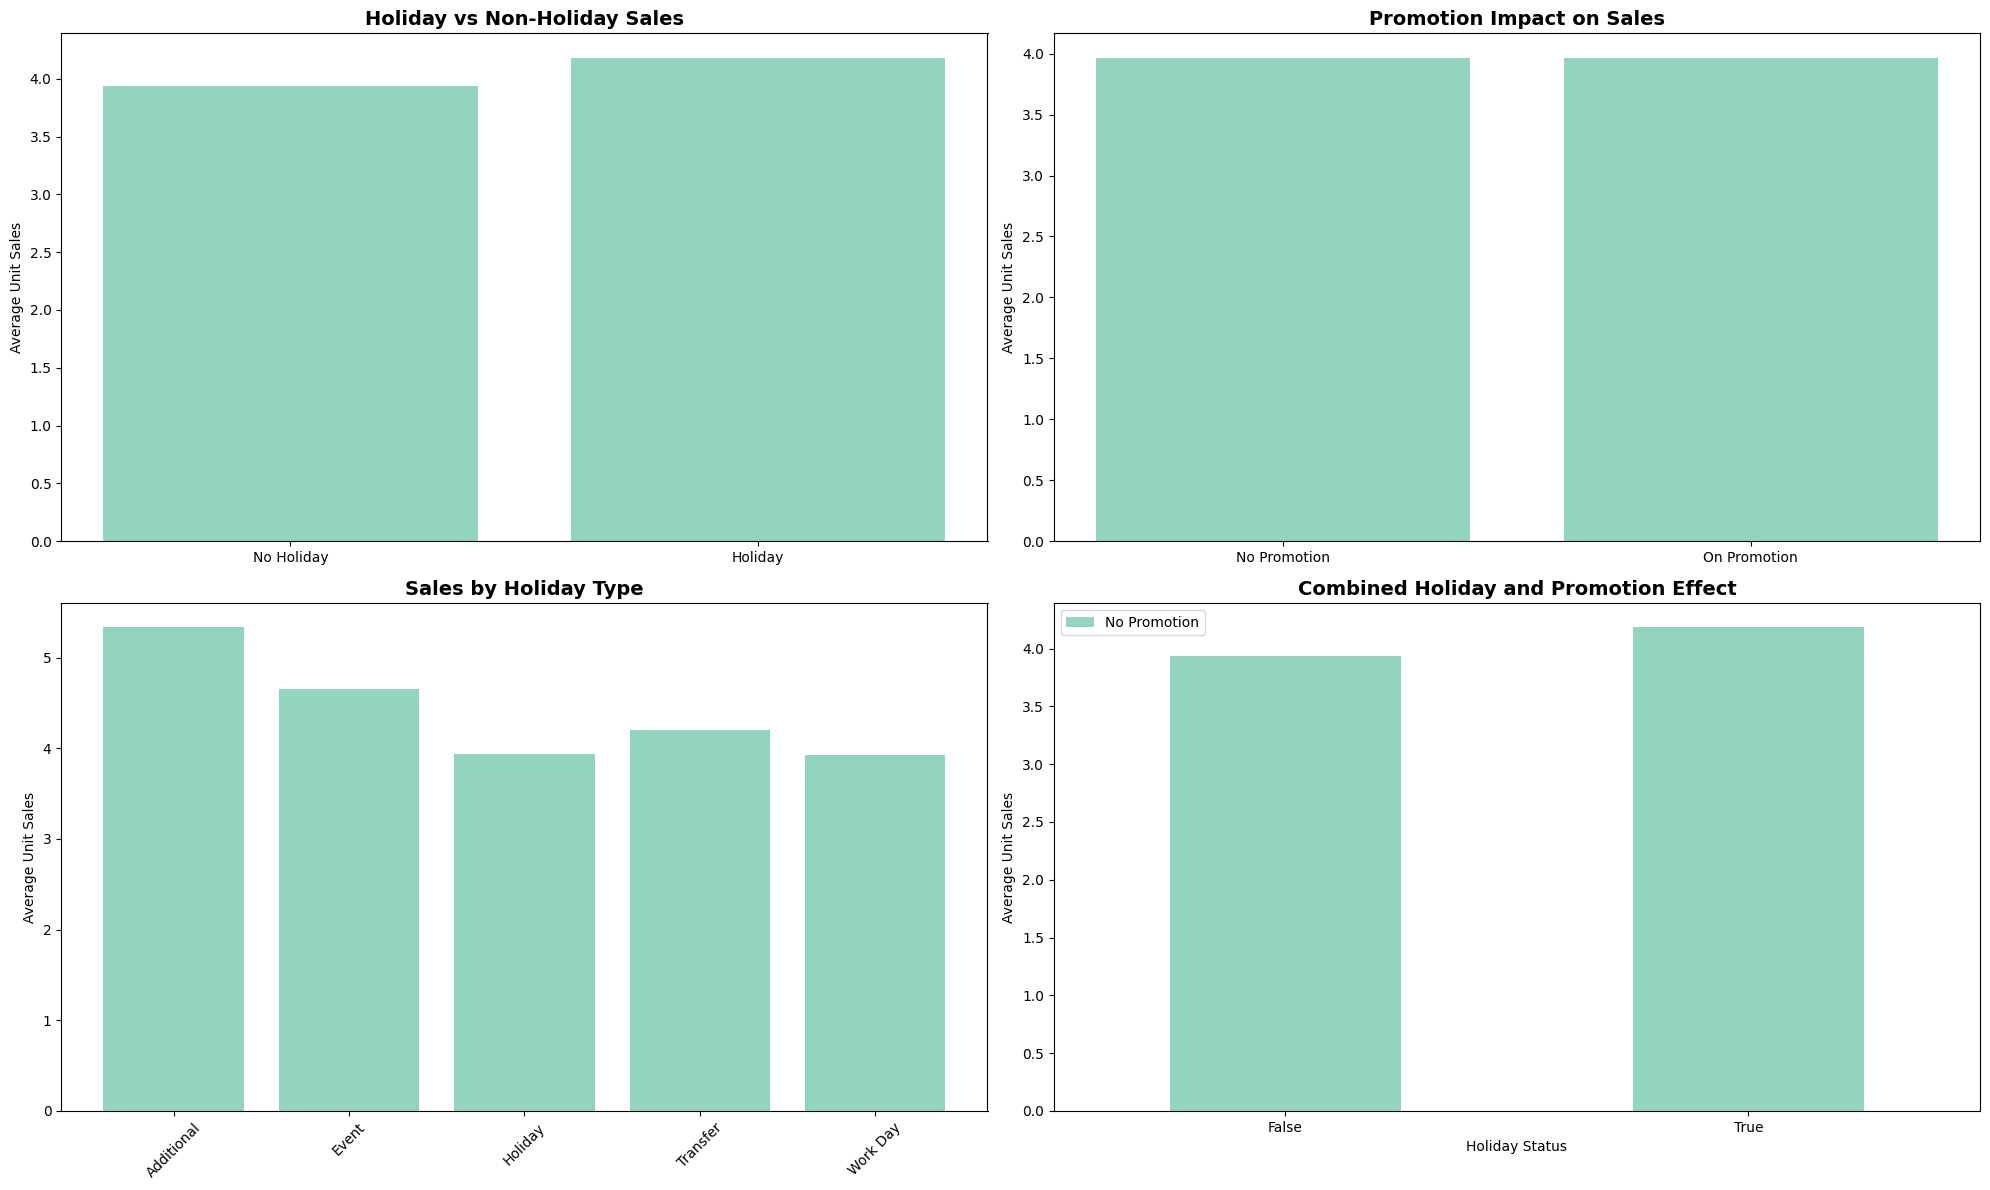

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Holiday impact
holiday_sales = df_train.groupby('is_holiday')['unit_sales'].mean()
axes[0,0].bar(['No Holiday', 'Holiday'], holiday_sales.values, alpha=0.7)
axes[0,0].set_title('Holiday vs Non-Holiday Sales', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Average Unit Sales')

# Promotion impact
promo_sales = df_train.groupby('onpromotion')['unit_sales'].mean()
axes[0,1].bar(['No Promotion', 'On Promotion'], promo_sales.values, alpha=0.7)
axes[0,1].set_title('Promotion Impact on Sales', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Average Unit Sales')

# Holiday types (if available)
if 'holiday_type' in df_train.columns and df_train['holiday_type'].notna().any():
  holiday_type_sales = df_train[df_train['holiday_type'].notna()].groupby('holiday_type')['unit_sales'].mean()
  axes[1,0].bar(range(len(holiday_type_sales)), holiday_type_sales.values, alpha=0.7)
  axes[1,0].set_title('Sales by Holiday Type', fontsize=14, fontweight='bold')
  axes[1,0].set_xticks(range(len(holiday_type_sales)))
  axes[1,0].set_xticklabels(holiday_type_sales.index, rotation=45)
  axes[1,0].set_ylabel('Average Unit Sales')

# Combined effect (Holiday + Promotion)
combined_effect = df_train.groupby(['is_holiday', 'onpromotion'])['unit_sales'].mean().unstack()
combined_effect.plot(kind='bar', ax=axes[1,1], alpha=0.7)
axes[1,1].set_title('Combined Holiday and Promotion Effect', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Holiday Status')
axes[1,1].set_ylabel('Average Unit Sales')
axes[1,1].legend(['No Promotion', 'On Promotion'])
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Store & Location Analysis

This section breaks down sales patterns across:
*	Store types and clusters
*	Cities
*	Top-performing stores

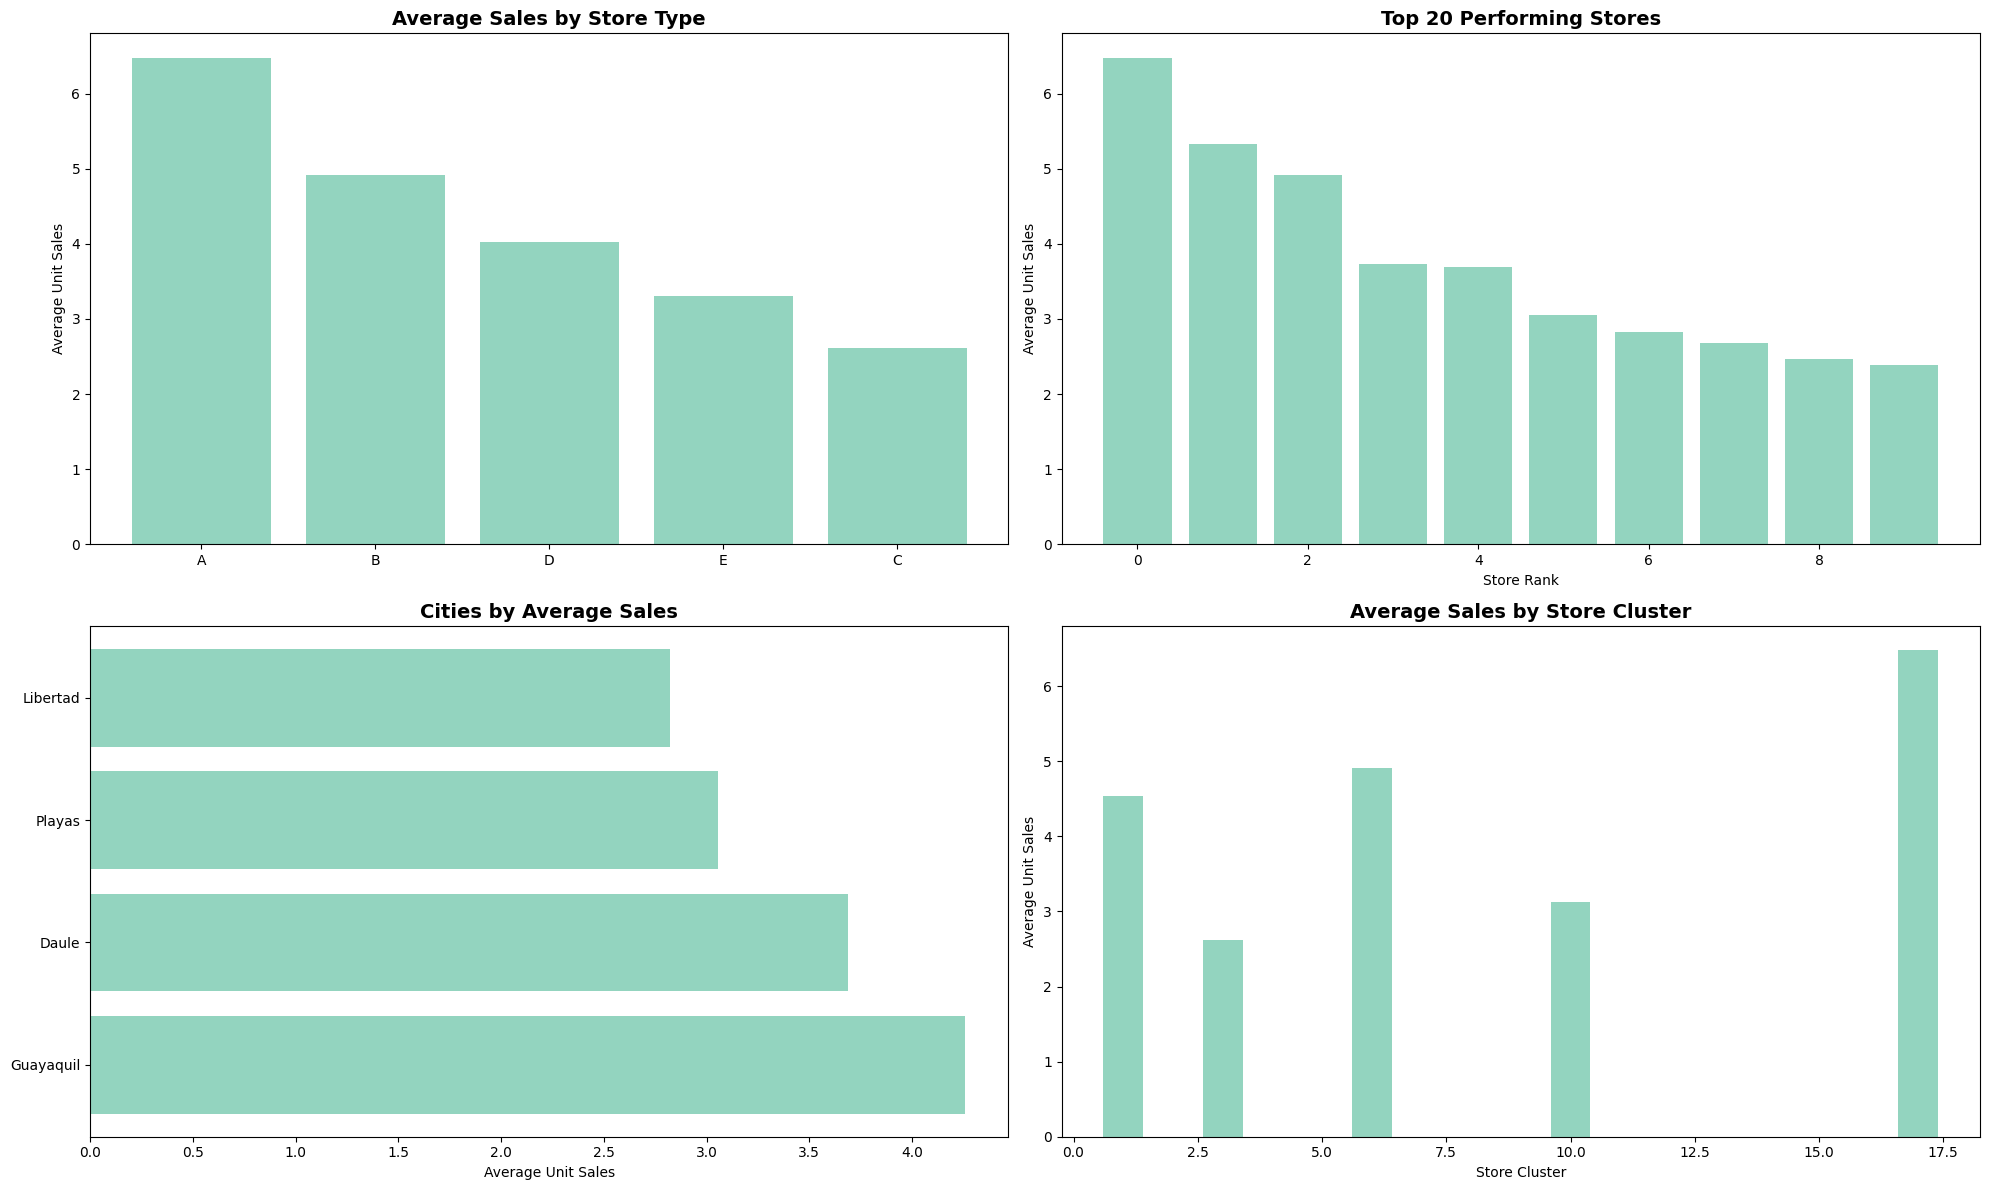

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Store type performance
store_type_sales = df_train.groupby('store_type')['unit_sales'].mean().nlargest()
axes[0,0].bar(store_type_sales.index, store_type_sales.values, alpha=0.7)
axes[0,0].set_title('Average Sales by Store Type', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Average Unit Sales')

#  stores
top_stores = df_train.groupby('store_nbr')['unit_sales'].mean().nlargest(20)
axes[0,1].bar(range(len(top_stores)), top_stores.values, alpha=0.7)
axes[0,1].set_title('Top 20 Performing Stores', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Store Rank')
axes[0,1].set_ylabel('Average Unit Sales')

# City performance
city_sales = df_train.groupby('city')['unit_sales'].mean().nlargest()
axes[1,0].barh(range(len(city_sales)), city_sales.values, alpha=0.7)
axes[1,0].set_title('Cities by Average Sales', fontsize=14, fontweight='bold')
axes[1,0].set_yticks(range(len(city_sales)))
axes[1,0].set_yticklabels(city_sales.index)
axes[1,0].set_xlabel('Average Unit Sales')

# Store cluster performance
cluster_sales = df_train.groupby('store_cluster')['unit_sales'].mean()
axes[1,1].bar(cluster_sales.index, cluster_sales.values, alpha=0.7)
axes[1,1].set_title('Average Sales by Store Cluster', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Store Cluster')
axes[1,1].set_ylabel('Average Unit Sales')

plt.tight_layout()
plt.show()

## Product Analysis

We analyze item attributes and their sales behavior:

*	Item families and classes
*	Perishable vs Non-perishable items
*	Top-selling item classes by average sales

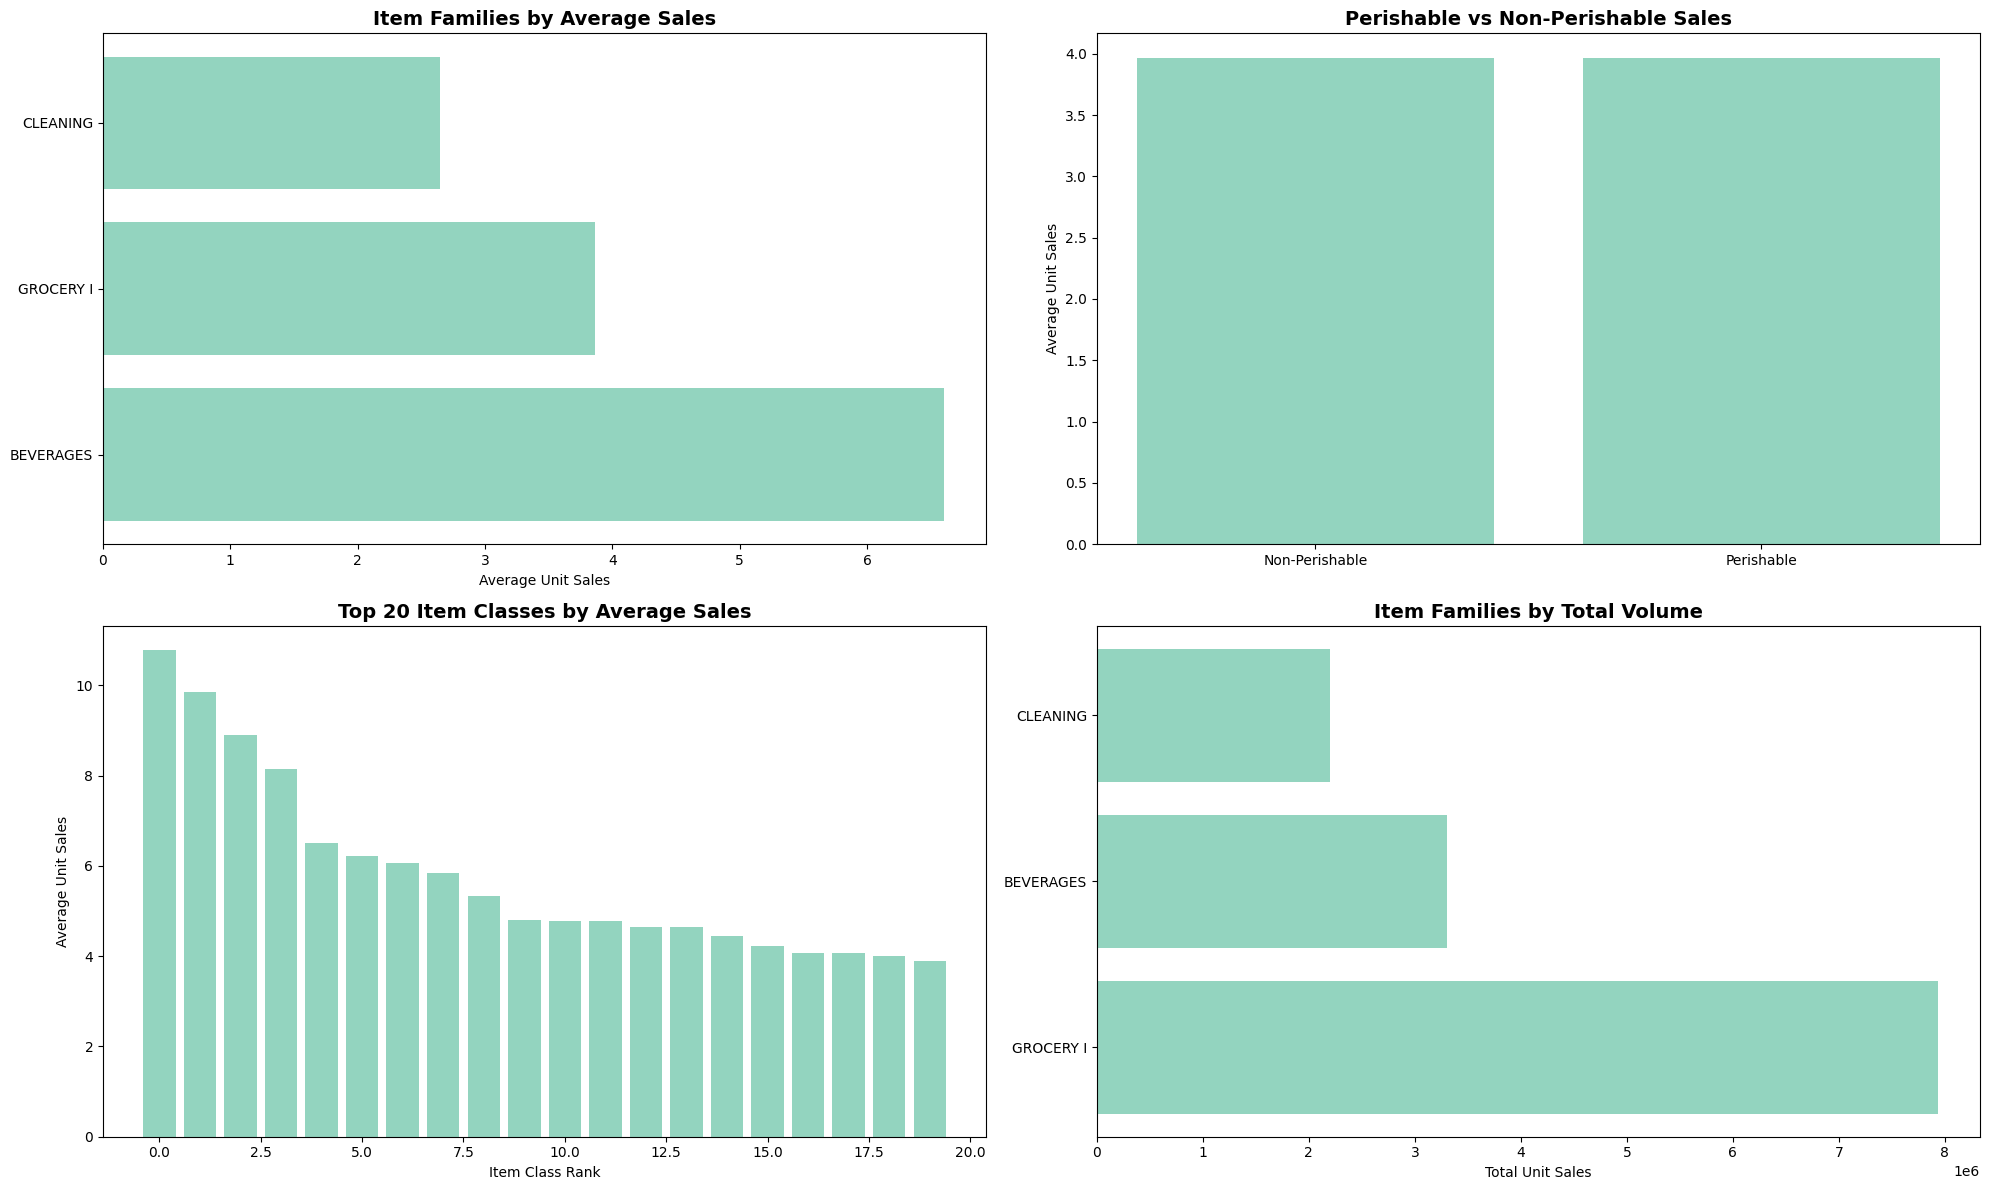

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Item family performance
family_sales = df_train.groupby('item_family')['unit_sales'].mean().nlargest()
axes[0,0].barh(range(len(family_sales)), family_sales.values, alpha=0.7)
axes[0,0].set_title('Item Families by Average Sales', fontsize=14, fontweight='bold')
axes[0,0].set_yticks(range(len(family_sales)))
axes[0,0].set_yticklabels(family_sales.index)
axes[0,0].set_xlabel('Average Unit Sales')

# Perishable vs non-perishable
perishable_sales = df_train.groupby('perishable')['unit_sales'].mean()
axes[0,1].bar(['Non-Perishable', 'Perishable'], perishable_sales.values, alpha=0.7)
axes[0,1].set_title('Perishable vs Non-Perishable Sales', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Average Unit Sales')

# Item class distribution (top 20)
class_sales = df_train.groupby('item_class')['unit_sales'].mean().nlargest(20)
axes[1,0].bar(range(len(class_sales)), class_sales.values, alpha=0.7)
axes[1,0].set_title('Top 20 Item Classes by Average Sales', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Item Class Rank')
axes[1,0].set_ylabel('Average Unit Sales')

# Sales volume by item family
family_volume = df_train.groupby('item_family')['unit_sales'].sum().nlargest()
axes[1,1].barh(range(len(family_volume)), family_volume.values, alpha=0.7)
axes[1,1].set_title('Item Families by Total Volume', fontsize=14, fontweight='bold')
axes[1,1].set_yticks(range(len(family_volume)))
axes[1,1].set_yticklabels(family_volume.index)
axes[1,1].set_xlabel('Total Unit Sales')

plt.tight_layout()
plt.show()

## Feature and Correlation Analysis

Using correlation matrices and scatter plots, we explore how features relate to each other and to `unit_sales`. This includes:

* Lag features
*	Rolling averages and standard deviations

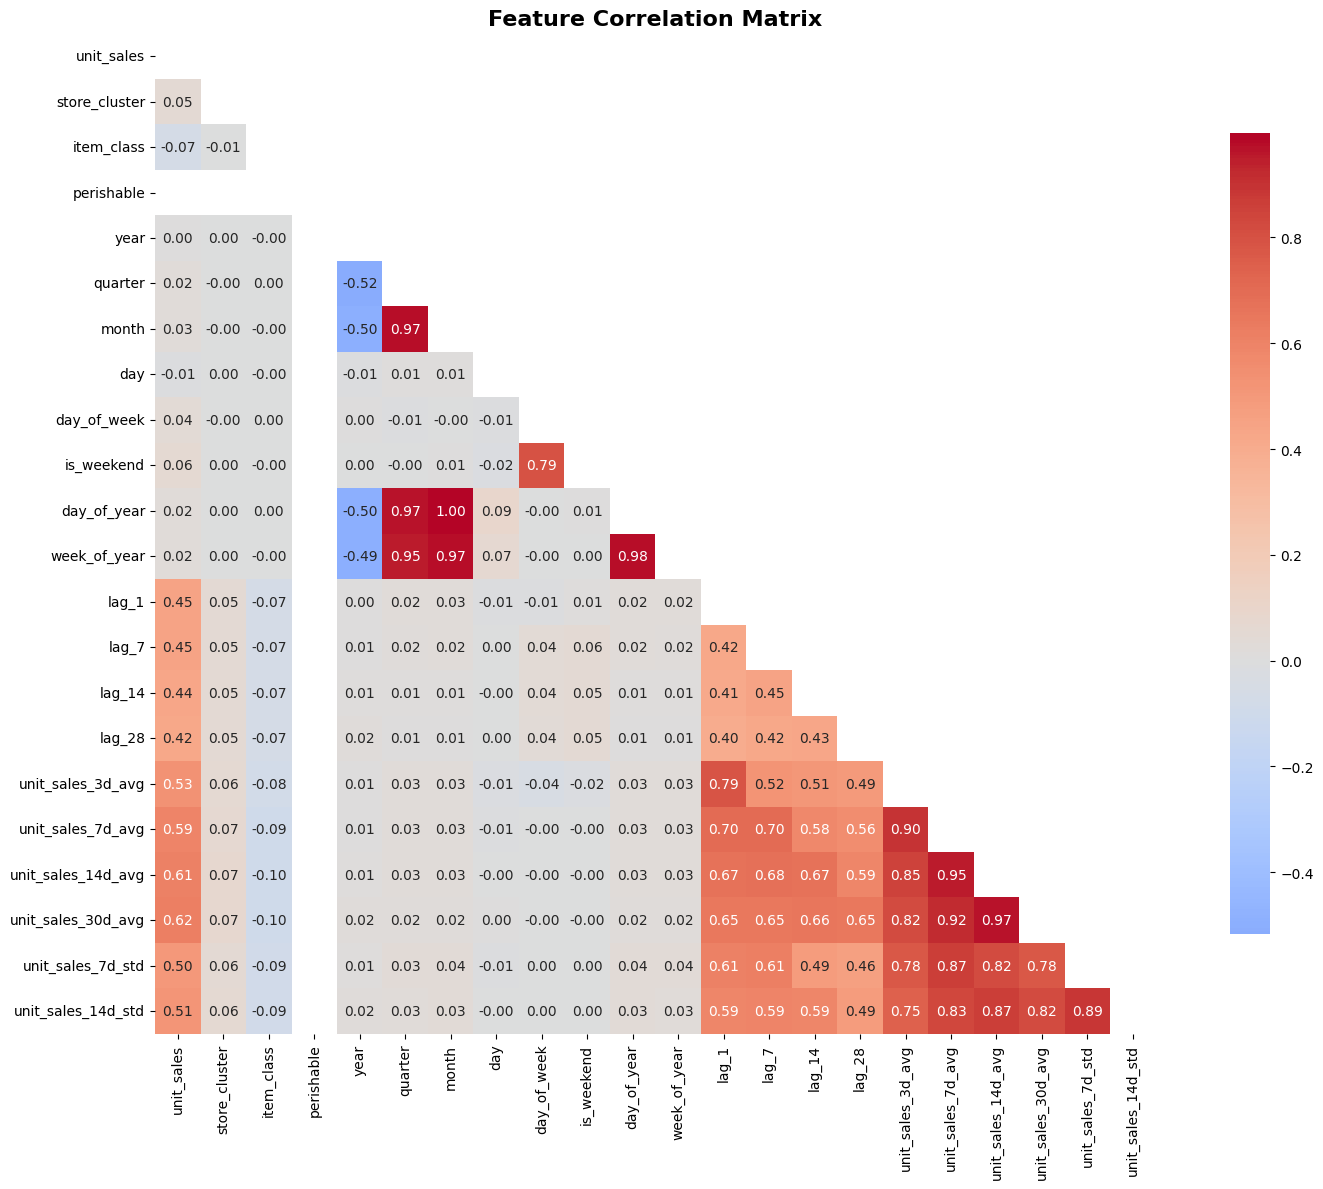

In [17]:
plt.figure(figsize=(16, 12))

# Select numerical columns for correlation
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID columns
numerical_cols = [col for col in numerical_cols if col not in ['store_nbr', 'item_nbr', 'id']]

corr_matrix = df_train[numerical_cols].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

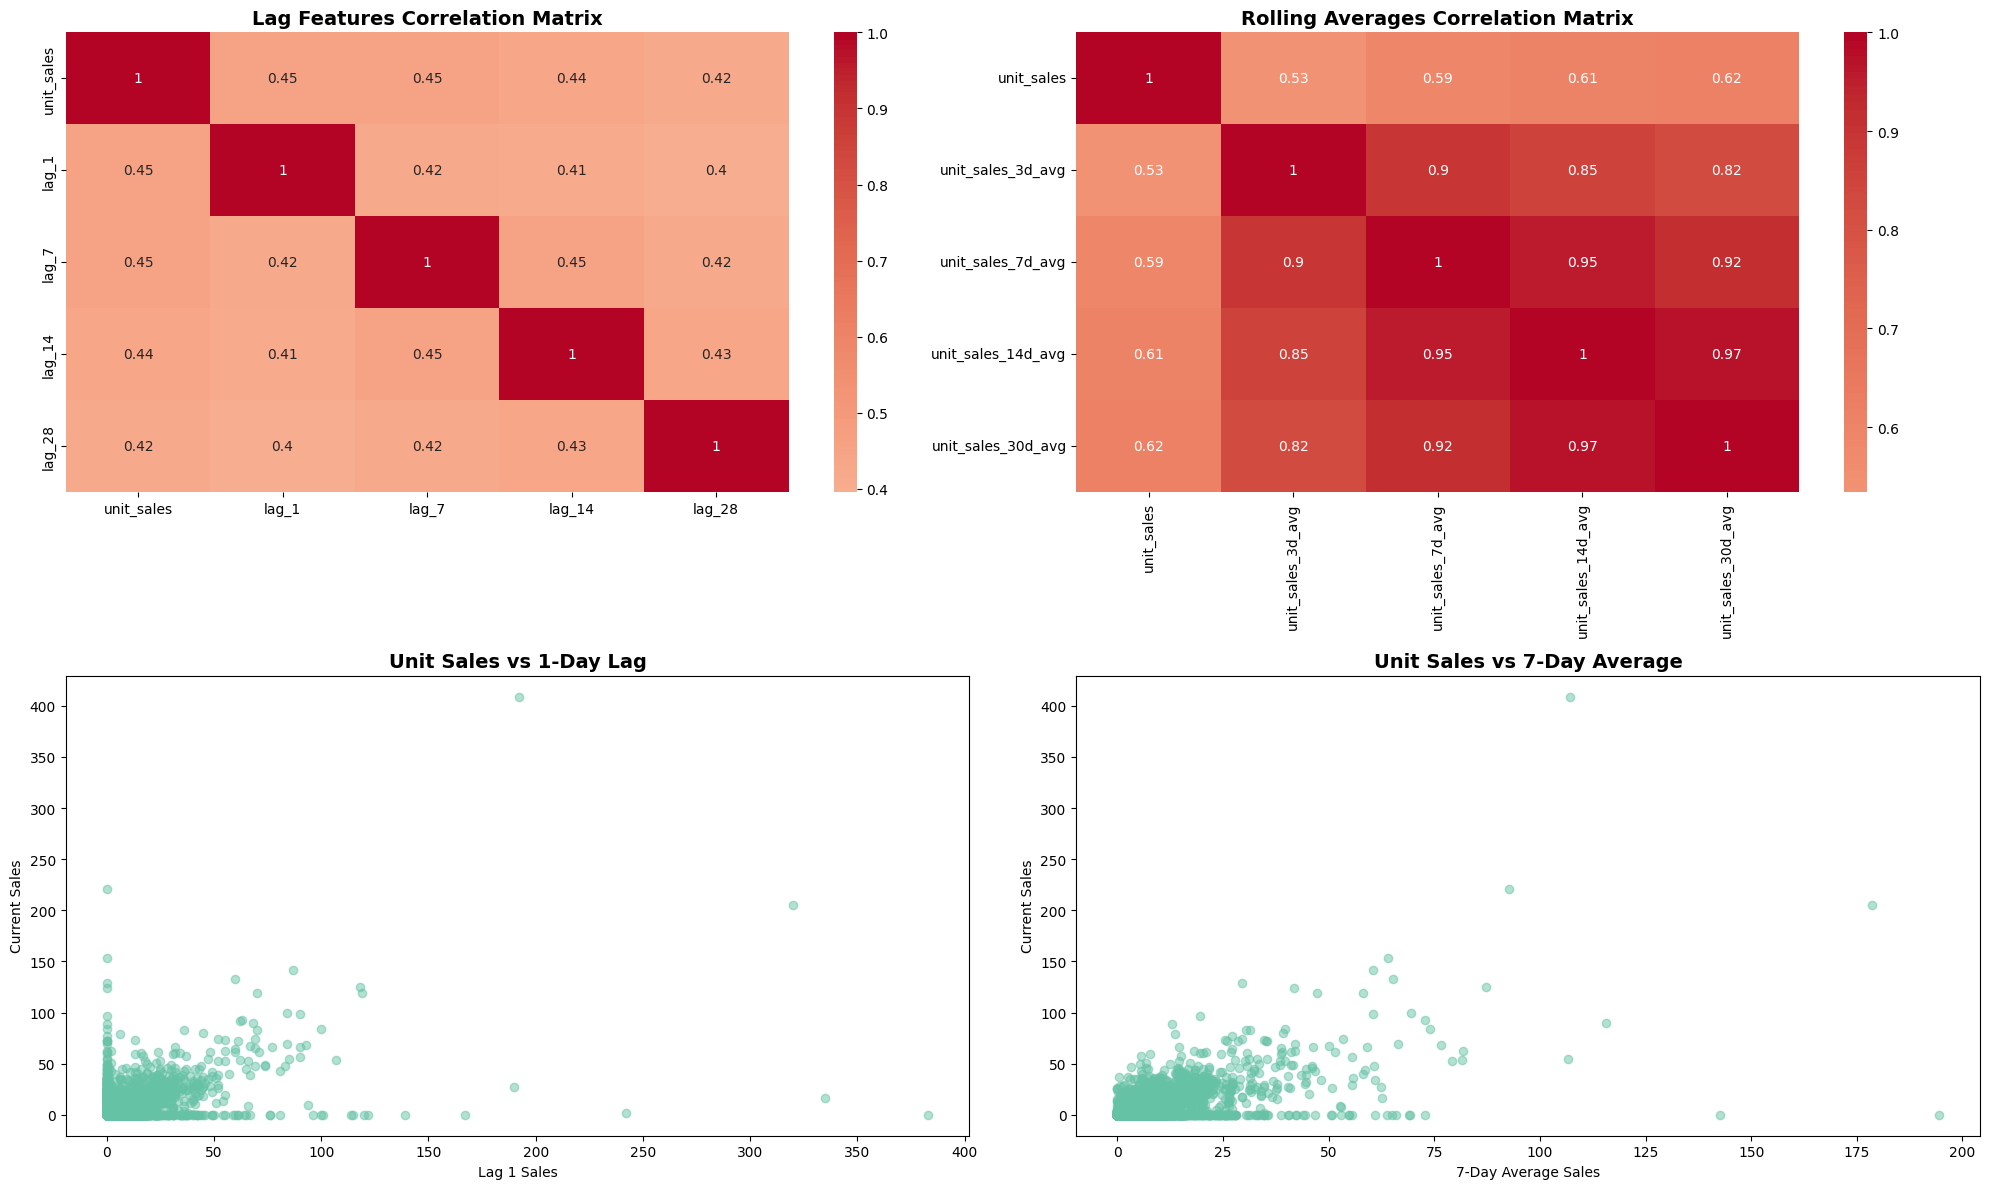

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Correlation between actual sales and lag features
lag_cols = ['unit_sales', 'lag_1', 'lag_7', 'lag_14', 'lag_28']
lag_corr = df_train[lag_cols].corr()

sns.heatmap(lag_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Lag Features Correlation Matrix', fontsize=14, fontweight='bold')

# Rolling averages correlation
rolling_cols = ['unit_sales', 'unit_sales_3d_avg', 'unit_sales_7d_avg',
                'unit_sales_14d_avg', 'unit_sales_30d_avg']
rolling_corr = df_train[rolling_cols].corr()

sns.heatmap(rolling_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
axes[0,1].set_title('Rolling Averages Correlation Matrix', fontsize=14, fontweight='bold')

# Scatter plot: Actual vs Lag_1
sample_data = df_train.sample(n=min(10000, len(df_train)))  # Sample for performance
axes[1,0].scatter(sample_data['lag_1'], sample_data['unit_sales'], alpha=0.5)
axes[1,0].set_title('Unit Sales vs 1-Day Lag', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Lag 1 Sales')
axes[1,0].set_ylabel('Current Sales')

# Scatter plot: Actual vs 7-day average
axes[1,1].scatter(sample_data['unit_sales_7d_avg'], sample_data['unit_sales'], alpha=0.5)
axes[1,1].set_title('Unit Sales vs 7-Day Average', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('7-Day Average Sales')
axes[1,1].set_ylabel('Current Sales')

plt.tight_layout()
plt.show()

## Outlier Analysis

We calculate z-scores within each (`store_nbr`, `item_nbr`) group to detect unusually high unit sales. While high values are detected, they reflect high-demand items rather than true outliers.

> **These “outliers” are not removed since they likely represent genuine peak sales.**



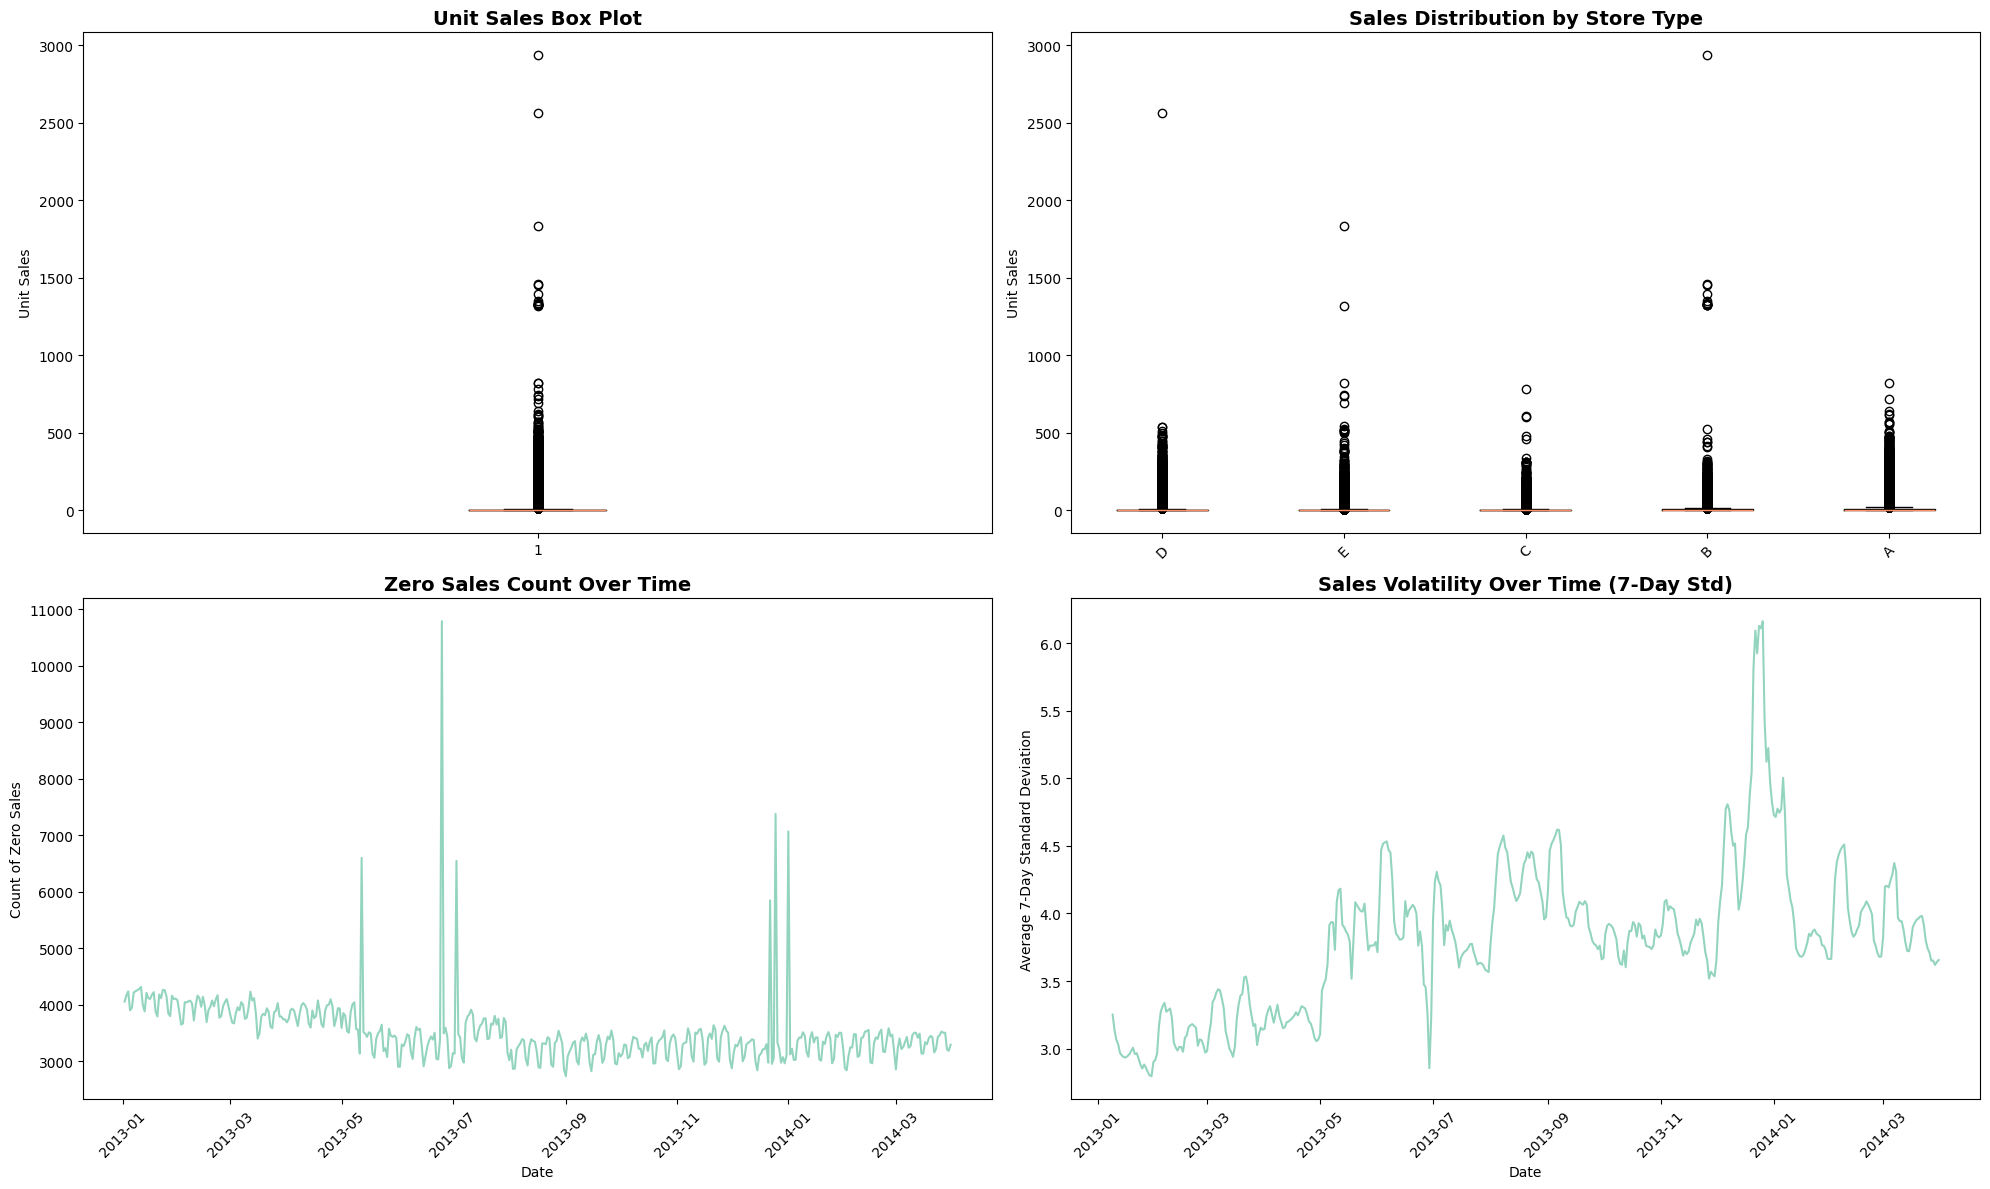

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Box plot of sales
axes[0,0].boxplot(df_train['unit_sales'])
axes[0,0].set_title('Unit Sales Box Plot', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Unit Sales')

# Sales by store type (box plot)
store_types = df_train['store_type'].unique()
sales_by_type = [df_train[df_train['store_type'] == st]['unit_sales'].values for st in store_types]
axes[0,1].boxplot(sales_by_type, tick_labels=store_types)
axes[0,1].set_title('Sales Distribution by Store Type', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Unit Sales')
axes[0,1].tick_params(axis='x', rotation=45)

# Zero sales analysis
zero_sales_by_date = df_train[df_train['unit_sales'] == 0].groupby('date').size()
if len(zero_sales_by_date) > 0:
  axes[1,0].plot(zero_sales_by_date.index, zero_sales_by_date.values, alpha=0.7)
  axes[1,0].set_title('Zero Sales Count Over Time', fontsize=14, fontweight='bold')
  axes[1,0].set_xlabel('Date')
  axes[1,0].set_ylabel('Count of Zero Sales')
  axes[1,0].tick_params(axis='x', rotation=45)

# Volatility analysis (7-day std)
volatility_by_date = df_train.groupby('date')['unit_sales_7d_std'].mean()
axes[1,1].plot(volatility_by_date.index, volatility_by_date.values, alpha=0.7)
axes[1,1].set_title('Sales Volatility Over Time (7-Day Std)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Average 7-Day Standard Deviation')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## External Factor: Oil Price Influence

We investigate the potential influence of **oil prices** on retail sales by:

* Merging daily oil prices with unit sales
*	Visualizing time-series trends
*	Computing a 30-day rolling correlation

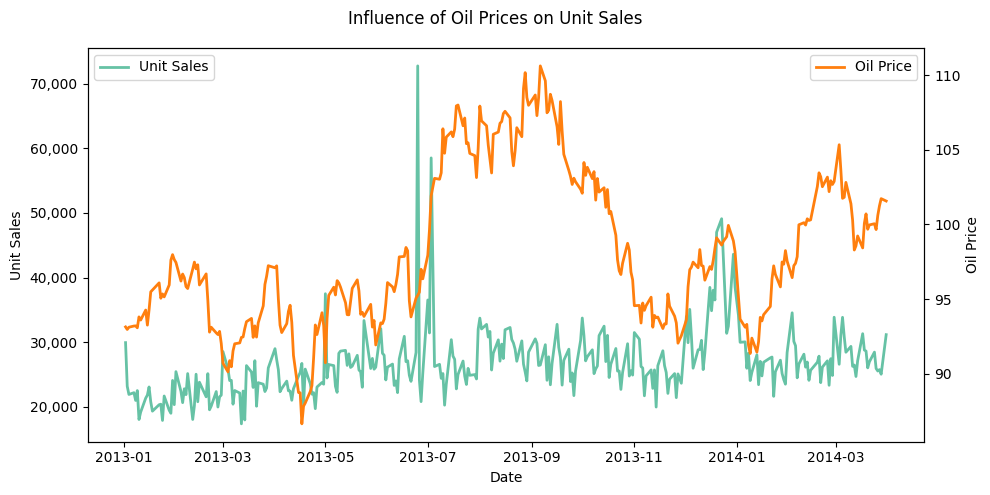

In [27]:
# Ensure datetime formats for merging and plotting
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Aggregate sales data by date (using 'unit_sales')
sales_by_date = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Merge aggregated sales with oil prices
merged_data = pd.merge(sales_by_date, df_oil, on='date', how='left')
del df_oil, sales_by_date  #clean up

# Rename columns for clarity
merged_data.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

# Drop rows where oil price is NaN
merged_data = merged_data.dropna(subset=['oil_price'])

# Plot unit sales and oil prices
fig, ax1 = plt.subplots(figsize=(10, 5))  # Bigger figure size for better readability

# Plot unit sales on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Unit Sales')
ax1.plot(merged_data['date'], merged_data['unit_sales'], label='Unit Sales', linewidth=2)
ax1.tick_params(axis='y')
ax1.tick_params(axis='x')

# Format y-axis for unit sales
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Plot oil prices on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price')
ax2.plot(merged_data['date'], merged_data['oil_price'], label='Oil Price', linewidth=2, color='tab:orange')
ax2.tick_params(axis='y')

# Add grid, titles, and legends
fig.suptitle('Influence of Oil Prices on Unit Sales')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

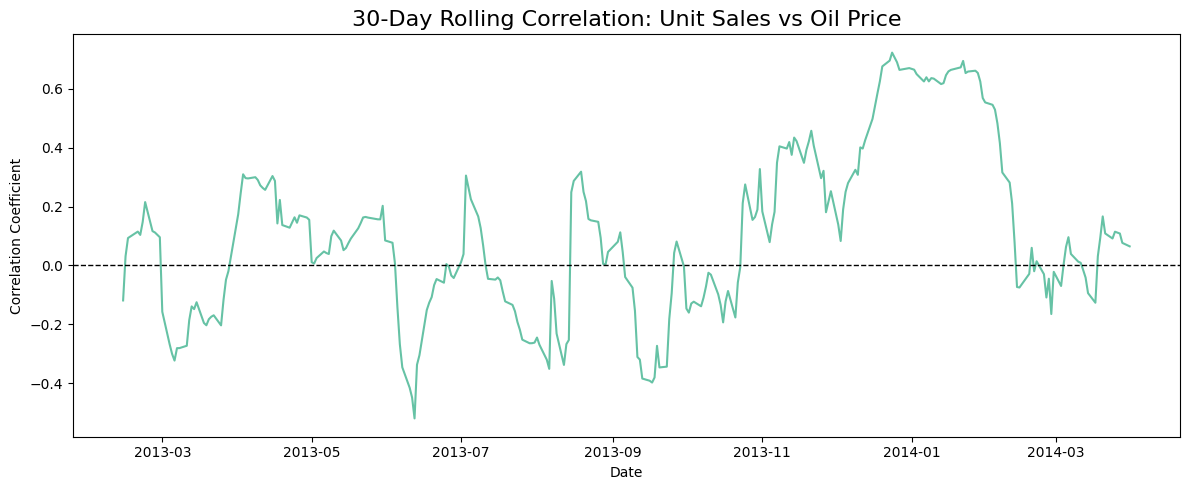

In [28]:
merged_data['rolling_corr'] = (
    merged_data['unit_sales'].rolling(30).corr(merged_data['oil_price'])
)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(merged_data['date'], merged_data['rolling_corr'])
plt.title('30-Day Rolling Correlation: Unit Sales vs Oil Price', fontsize=16)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Date')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# Conclusion: Exploratory Data Analysis

This EDA phase provided valuable insights into the structure and behavior of the retail dataset. Below is a summary of key findings:

**Dataset Insights**
*	The dataset spans from 2013-01-02 to 2014-03-31, covering over 5.2 million records across 10 stores and 1448 items.
*	Approximately 62% of the records represent zero unit sales, reflecting the sparse nature of retail demand data.

**Temporal Patterns**
*	Clear weekly seasonality is observed, with sales peaking on weekends (especially Saturdays and Sundays).
*	Monthly trends show fluctuations, with strong sales in December, hinting at a year-end holiday effect.
*	Sales volatility increases over time, suggesting growing demand variability.

**Store & Item Behavior**
*	Store types A and B show higher average sales compared to others.
*	Top-performing stores contribute significantly more to total sales than lower-ranked stores.
*	Perishable and non-perishable items exhibit similar sales volumes, but different behaviors across families.
*	The item family “GROCERY I” dominates in both average and total volume of unit sales.

**Promotion & Holidays**
*	Promotions and holidays individually show a small positive lift in sales.
*	Additional holidays lead to notably higher sales than standard holidays.
*	The combined effect of holiday + promotion is not significantly stronger than each factor alone.

**Oil Price Impact**
*	A potential relationship between oil prices and sales was explored using a 30-day rolling correlation.
*	The correlation fluctuates over time, with short periods of positive and negative correlation, suggesting no strong linear relationship but some temporal influence.

**Outliers**
*	High unit sales with z-scores > 5 were identified in specific store-item combinations.
*	These are retained as they likely represent real demand spikes rather than data errors.